In [185]:

import pandas as pd
import numpy as np  
import os 
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Sequence, Dict, Any, List
import copy

pd.set_option("display.max_columns", 200)

In [186]:
os.chdir((Path.home()/"wdpath.txt").read_text().strip())

### Load Data

In [187]:
with open("processed-data/003-dat-dict.pkl",'rb') as f:
    dat_dict = pickle.load(f)

### Clean Data

In [188]:

def filter_se(
    SE: Dict[str, Any],
    margin: int,
    indices: Sequence
) -> Dict[str, Any]:
    """
    Filter a SingleCellExperiment-style dictionary.

    Parameters
    ----------
    SE : dict
        A data dict with 'counts', 'logcounts', 'rowData', 'colData', and 'rDims'.
    margin : int
        0 = filter rows (genes)
        1 = filter columns (samples)
    indices : sequence of int or bool
        Indices to keep.

    Returns
    -------
    dict
        A new filtered SE dictionary.
    """

    # Validate margin
    if margin not in (0, 1):
        raise ValueError("margin must be 0 (rows/genes) or 1 (columns/samples)")

    # Convert indices to a numpy array for consistent handling
    idx = np.asarray(indices)

    # Deep copy rDims so the original SE is not modified
    new_rDims = copy.deepcopy(SE["rDims"])

    if margin == 0:
        # Filter genes (rows)
        return {
            "logcounts": SE["logcounts"].iloc[idx, :],
            "counts": SE["counts"].iloc[idx, :],
            "rowData": SE["rowData"].iloc[idx, :],
            "colData": SE["colData"],   # unchanged
            "rDims": new_rDims          # unchanged
        }

    # margin == 1: filter samples (columns)
    # Update rDims sample-level embeddings
    for method in new_rDims:
        if "scores" in new_rDims[method]:
            new_rDims[method]["scores"] = new_rDims[method]["scores"][idx]

    return {
        "logcounts": SE["logcounts"].iloc[:, idx],
        "counts": SE["counts"].iloc[:, idx],
        "rowData": SE["rowData"],               # unchanged
        "colData": SE["colData"].iloc[idx, :],
        "rDims": new_rDims
    }


In [189]:
# make AGE two columns
dat_dict['colData'] = (
    dat_dict['colData']
        .assign(
            AGE_lwr = dat_dict['colData']['AGE'].str.split('-', expand=True)[0].astype(float),
            AGE_upr = dat_dict['colData']['AGE'].str.split('-', expand=True)[1].astype(float)
        )
)

# make SEX female binary column
dat_dict['colData'] = (
    dat_dict['colData']
    .assign(
        SEXF = (dat_dict['colData'].SEX == 2).astype(int)
    )
)


### Tasks:
__Ensemble-Based Models to Predict Tissue__

Using projected samples from the latent spaces:

1. Use **at least two ensemble approaches** to predict tissue of origin:
   - One approach must use an estimator that **tends to overfit**.
   - Another must use a **weak learner** that slightly outperforms random guessing.
2. Use an appropriate **model evaluation strategy** to tune hyperparameters and assess:
   - Prediction quality across tissues  
   - Generalization on unseen data  
   - Consider using `classification_report` from sklearn.

__Ensemble-Based Models to Predict Age__

Using **blood samples** and their projections into latent spaces:

1. Use at least two ensemble approaches to predict **age as a continuous variable**.  
2. Use a model evaluation strategy to:
   - Tune hyperparameters  
   - Assess prediction quality  
   - Evaluate generalization on unseen data  



## Predict Tissue From Latent Dimensions

In [190]:
from sklearn.model_selection import train_test_split

# make modeling objects
X_ = dat_dict['rDims']['PCA']['scores']
y_ = dat_dict['colData'].SMTS

X_train, X_test, y_train, y_test = train_test_split( X_, y_, test_size=0.99, random_state=100)


In [191]:
print(X_train.shape)
print(X_test.shape)

(124, 50)
(12336, 50)


### Ensemble of Overfitting Learners

Make random forest classifier by bagging a bunch of decision trees

In [192]:

from sklearn.tree import DecisionTreeClassifier 

# make a forest of decision trees
def random_forest(X: np.ndarray, y: np.ndarray, n_subset: int = 10, n_models: int = 300,max_depth: int = 5,seed: int = 0) -> List[DecisionTreeClassifier]:
    """
    Simple random forest using bootstrapped decision trees.

    Parameters
    ----------
    X : np.ndarray
        Data matrix (n_samples × n_features).
    y : np.ndarray
        Labels (n_samples,).
    n_subset : int, default=10
        Number of bootstrap samples per tree.
    n_models : int, default=300
        Number of trees in the ensemble.
    max_depth : int, default=5
        Max depth of each decision tree.
    seed : int, default=0
        Reproducibility seed.

    Returns
    -------
    List[DecisionTreeClassifier]
        Trained ensemble of decision tree classifiers.
    """

    X = np.asarray(X)
    y = np.asarray(y)

    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of samples")

    np.random.seed(seed)

    forest = []

    for _ in range(n_models):
        rw_idx = np.random.choice(X.shape[0], size=n_subset, replace=False)
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(X[rw_idx], y[rw_idx])
        forest.append(clf)  

    return forest

# extract classification probs for each tree and average them
def get_probabilities(X, clf_list: List, all_classes):
    # make predictions with each tree
    predictions = [
        pd.DataFrame(clf.predict_proba(X), columns=clf.classes_)
        for clf in clf_list
    ]

    # set each predicitno matrix to have same number of classes
    columned_predictions = []
    for pred in predictions:
        # missing column
        missing_cols = set(all_classes).difference(pred.columns)
        # add zero-filled columns
        for col in missing_cols:
            pred[col] = np.zeros(pred.shape[0])
        # Reorder columns alphabetically (left → right)
        pred.sort_index(axis=1, inplace=True)
        columned_predictions.append(pred)

    # average predictions
    average_prediction = sum(columned_predictions) / len(columned_predictions)

    return average_prediction

# assign class as column where probability maximized
def pred_class(X, clf_list: List, classes):
    # get average probabilies for each class across tree predictions
    prob = get_probabilities(X, clf_list, classes)
    # assign class where max probability
    pred = prob.columns[prob.to_numpy().argmax(axis=1)]
    
    return pred


Train `random_forest` on X_train

In [193]:

forest = random_forest(X_train, y_train, n_subset = 100, n_models = 5, max_depth = 200, seed = 10209)


Evaluate model

In [194]:
from sklearn.metrics import classification_report


y_train_pred = pred_class(X_train, forest, y_train.unique())
y_test_pred = pred_class(X_test, forest, y_test.unique())
    

print("\\\\ Train Classification Report \\\\\n",classification_report(y_train, y_train_pred, zero_division=0))
print("\\\\ Test Classification Report \\\\\n",classification_report(y_test, y_test_pred, zero_division=0))


\\ Train Classification Report \\
                 precision    recall  f1-score   support

Adipose Tissue       1.00      1.00      1.00        12
         Blood       1.00      1.00      1.00        10
  Blood Vessel       1.00      1.00      1.00        18
         Brain       0.96      1.00      0.98        22
         Colon       1.00      1.00      1.00        11
     Esophagus       1.00      1.00      1.00        19
         Heart       1.00      1.00      1.00         7
        Muscle       1.00      1.00      1.00         6
          Skin       1.00      1.00      1.00        14
       Thyroid       1.00      0.80      0.89         5

      accuracy                           0.99       124
     macro avg       1.00      0.98      0.99       124
  weighted avg       0.99      0.99      0.99       124

\\ Test Classification Report \\
                 precision    recall  f1-score   support

Adipose Tissue       0.91      0.90      0.91      1192
         Blood       0.99      

        This model overfits because the training accuracy is much higher than the testing accuracy. It has a high variance

### Ensemble of Underfitting Learners

Fit adaboost classifier

In [195]:
from sklearn.ensemble import AdaBoostClassifier

# Create and fit an AdaBoosted decision tree
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=500)
ada.fit(X_train, y_train)


,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,500
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,None
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


Evaluate model

In [196]:
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
    

In [197]:

print("\\\\ Train Classification Report \\\\\n",classification_report(y_train, y_train_pred, zero_division=0))
print("\\\\ Test Classification Report \\\\\n",classification_report(y_test, y_test_pred, zero_division=0))


\\ Train Classification Report \\
                 precision    recall  f1-score   support

Adipose Tissue       0.00      0.00      0.00        12
         Blood       0.00      0.00      0.00        10
  Blood Vessel       0.88      0.83      0.86        18
         Brain       0.67      1.00      0.80        22
         Colon       0.00      0.00      0.00        11
     Esophagus       0.63      0.89      0.74        19
         Heart       0.00      0.00      0.00         7
        Muscle       0.00      0.00      0.00         6
          Skin       0.30      1.00      0.46        14
       Thyroid       0.00      0.00      0.00         5

      accuracy                           0.55       124
     macro avg       0.25      0.37      0.29       124
  weighted avg       0.38      0.55      0.43       124

\\ Test Classification Report \\
                 precision    recall  f1-score   support

Adipose Tissue       0.00      0.00      0.00      1192
         Blood       0.00      

        This model underfits because both the training and testing are low. Because they are about the same this model has high bias and low variance

## Predict Age 

In [198]:
# extract blood 
blood_dict = filter_se(SE = dat_dict, margin = 1,  indices=(dat_dict['colData'].SMTS=="Blood").values)
blood_dict['colData'].SMTS.unique()

array(['Blood'], dtype=object)

In [199]:
def print_keys(d, level=0):
    for key, value in d.items():
        print("  " * level + str(key))
        if isinstance(value, dict):
            print_keys(value, level + 1)

print_keys(blood_dict)

logcounts
counts
rowData
colData
rDims
  PCA
    scores
    attributes
  NMF
    scores
    attributes


### Use Random Forest to Predict Age

In [200]:
print(np.shape(blood_dict['rDims']["PCA"]['scores']))
print(blood_dict['colData'].shape)
print(type(blood_dict['colData']))
print(type(blood_dict['rDims']['PCA']['scores']))



(929, 50)
(929, 70)
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [201]:
X_, y_ = blood_dict['rDims']["PCA"]['scores'] , blood_dict['colData'].AGE_lwr

# Data sets
X_train, X_test, y_train, y_test = train_test_split(X_, y_,random_state=120290, train_size=.66)


In [202]:

from sklearn.ensemble import RandomForestRegressor



In [203]:
from itertools import product

n_estimators = np.arange(100, 501, 20)
depths       = np.arange(2, 11 )       

pars = list(product(n_estimators, depths))
print(len(pars))

# res = []
# for n_est, depth in pars:
#     rfReg = RandomForestRegressor(
#         max_depth=depth, 
#         n_estimators=n_est
#     )

#     rfReg.fit(X_train, y_train)
#     pred = rfReg.predict(X_train)
#     rmse = np.sqrt(np.mean((pred - y_train)**2))

#     res.append({"n_estimators": n_est,
#                     "max_depth": depth,
#                     "rmse": rmse})
# res = pd.DataFrame(res)
# pickle.dump(file=open('results/rfReg-param-search.pkl', 'wb') , obj=res)


189


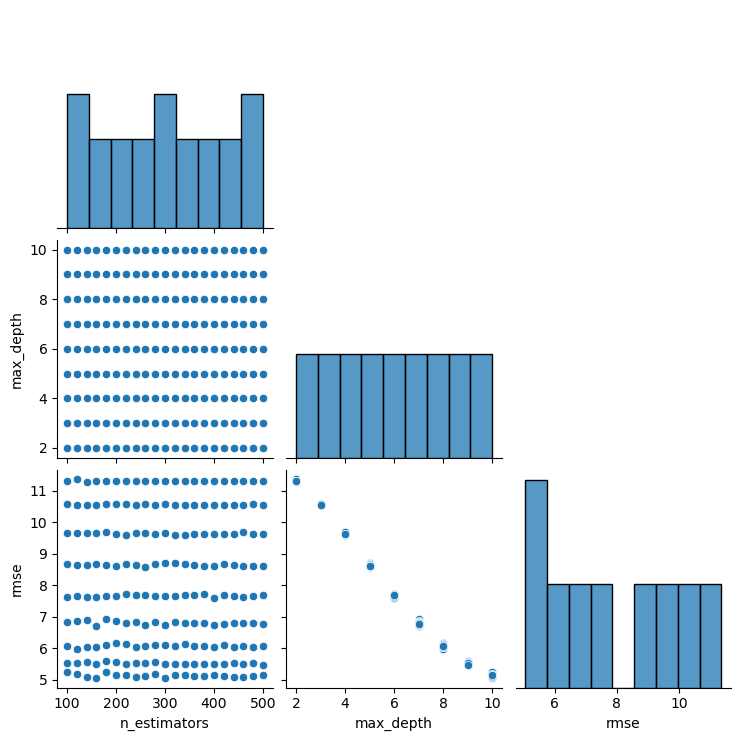

In [204]:
res = pickle.load(open("results/rfReg-param-search.pkl", 'rb'))
res.head()
sns.pairplot(res,corner=True)
plt.show()

In [205]:

# train model
rfReg = RandomForestRegressor(n_estimators=100, random_state= 100, max_depth = 10)

rfReg.fit(X_train, y_train)

y_train_pred = rfReg.predict(X_train)
y_test_pred = rfReg.predict(X_test)

In [206]:

def eval(predicted, true):
    predicted , true =  np.asarray(predicted) , np.asarray(true)
    rmse = np.sqrt(np.mean((predicted-true)**2))
    mse = np.mean((predicted-true)**2)
    return f"RMSE= {rmse}"


In [207]:

print("\\\\ Train Classification Report \\\\",
      '\n', eval(y_train_pred, y_train))

print("\b")

print("\\\\ Test Classification Report \\\\",
      '\n', eval(y_test_pred, y_test))

\\ Train Classification Report \\ 
 RMSE= 5.072483311865816

\\ Test Classification Report \\ 
 RMSE= 13.01277378077845


### Use Gradient Boosting to Predict Age

In [208]:
from sklearn.ensemble import GradientBoostingRegressor


Tune Hyperparameters

In [209]:

n_estimators = np.arange(100, 501, 20)
depths       = np.arange(2, 11 )       

pars = list(product(n_estimators, depths))
print(len(pars))

# res = []
# for n_est, depth in pars:
#     gbReg = GradientBoostingRegressor(
#         loss="squared_error",
#         alpha=.95,
#         n_estimators=n_est,
#         max_depth=depth,
#         learning_rate=0.2,
#         min_samples_leaf=9,
#         min_samples_split=9
#     )

#     gbReg.fit(X_train, y_train)
#     pred = gbReg.predict(X_train)
#     rmse = np.sqrt(np.mean((pred - y_train)**2))

#     res.append({"n_estimators": n_est,
#                     "max_depth": depth,
#                     "rmse": rmse})
# res = pd.DataFrame(res)
# pickle.dump(file=open('results/gbReg-param-search.pkl', 'wb') , obj=res)


189


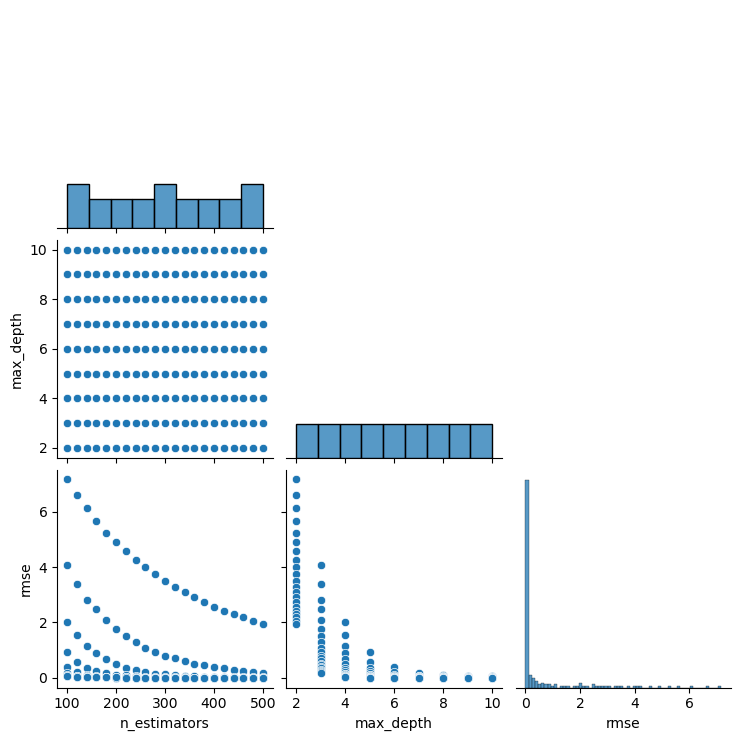

In [210]:
res = pickle.load(open('results/gbReg-param-search.pkl', 'rb'))
res.head()
sns.pairplot(res,corner=True)
plt.show()

In [211]:
# train model
gbReg = GradientBoostingRegressor(
    loss="squared_error",
    alpha=.95,
    n_estimators=300,
    max_depth=10,
    learning_rate=0.2,
    min_samples_leaf=9,
    min_samples_split=9)

gbReg.fit(X_train, y_train)


y_train_pred = gbReg.predict(X_train)
y_test_pred = gbReg.predict(X_test)


In [212]:


print("\\\\ Train Classification Report \\\\",
      '\n', eval(y_train_pred, y_train))

print("\b")

print("\\\\ Test Classification Report \\\\",
      '\n', eval(y_test_pred, y_test))

\\ Train Classification Report \\ 
 RMSE= 0.00032460832342259366

\\ Test Classification Report \\ 
 RMSE= 13.477965895478732


In [213]:
from sklearn.linear_model import Ridge, LinearRegression

# lin_fit = LinearRegression()
lin_fit = Ridge(alpha = 10, solver = 'sag', random_state = 103)

lin_fit.fit(X_train, y_train)


train_pred = lin_fit.predict(X_train)
test_pred = lin_fit.predict(X_test)


print('|avg(coef)| = ', abs(lin_fit.coef_).mean())
print("Train "+eval(train_pred, y_train))
print("Test "+ eval(test_pred, y_test))



|avg(coef)| =  0.5507590096800891
Train RMSE= 11.229423882592561
Test RMSE= 13.277264348202012
